<a href="https://colab.research.google.com/github/Joshuaisikah/BWM-XMD-QUANTUM/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive
import zipfile
import requests
from torchvision.utils import save_image, make_grid
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4


In [ ]:


# Set your Google Drive path here
drive_zip_path = '/content/drive/MyDrive/cnn_part_2_dataset.zip'  # Update this path
extract_path = '/content/dataset'

# Extract dataset from Google Drive
extract_dataset(drive_zip_path, extract_path)

Dataset extracted to: /content/dataset


In [ ]:
def extract_dataset(zip_path, extract_to):
    """Extracts a zip file to a specified directory.

    Args:
        zip_path (str): The path to the zip file.
        extract_to (str): The directory to extract the contents to.
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Dataset extracted to: {extract_to}")

In [99]:

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = ['dogs', 'vehicles', 'food']

        # Load images from each category
        for idx, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

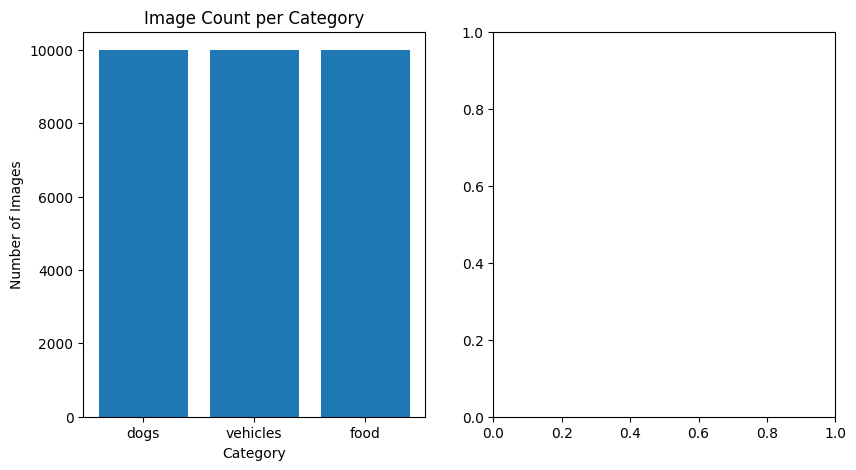

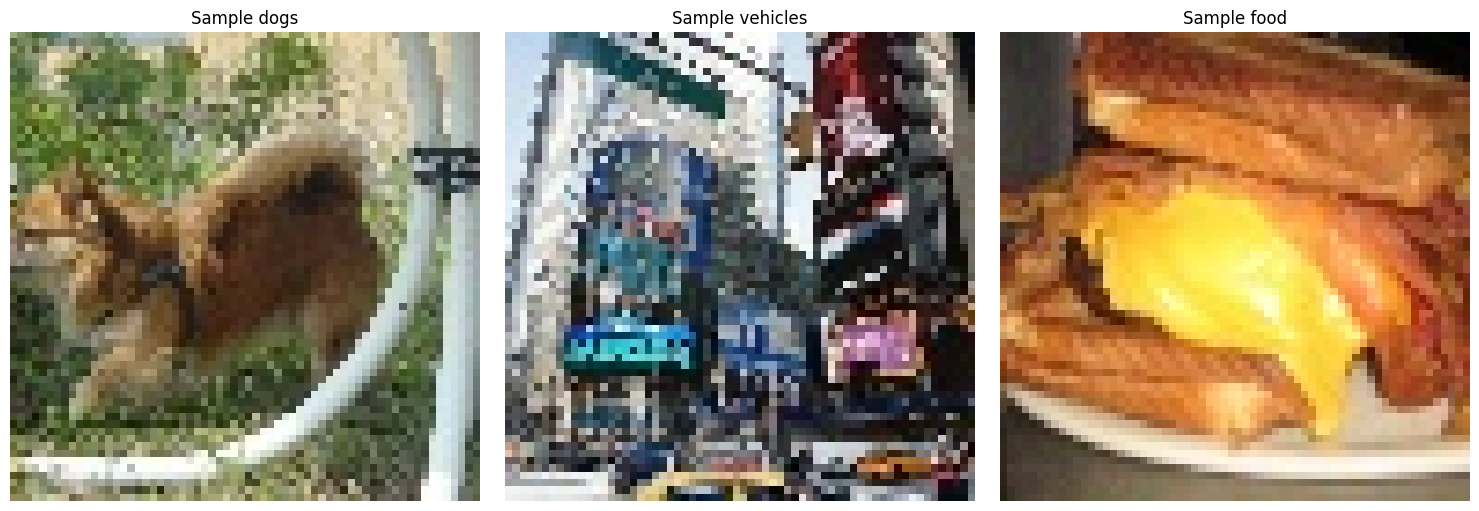

In [100]:
dataset_path = '/content/dataset'  # Update this path after extraction

# Create dataset visualization
def visualize_dataset(dataset_path):
    """Create visualizations for dataset exploration"""
    categories = ['dogs', 'vehicles', 'food']
    category_counts = {}

    # Count images per category
    for category in categories:
        cat_path = os.path.join(dataset_path, category)
        if os.path.exists(cat_path):
            count = len([f for f in os.listdir(cat_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            category_counts[category] = count
        else:
            category_counts[category] = 0

    # Plot category distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.bar(category_counts.keys(), category_counts.values())
    plt.title('Image Count per Category')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')

    # Show sample images from each category
    plt.subplot(1, 3, 2)
    sample_images = []
    for i, category in enumerate(categories):
        cat_path = os.path.join(dataset_path, category)
        if os.path.exists(cat_path):
            files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if files:
                sample_path = os.path.join(cat_path, files[0])
                img = Image.open(sample_path).convert('RGB')
                sample_images.append(img)

    if sample_images:
        fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
        for i, (img, cat) in enumerate(zip(sample_images, categories)):
            axes[i].imshow(img)
            axes[i].set_title(f'Sample {cat}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return category_counts

# Visualize dataset
category_counts = visualize_dataset(dataset_path)

# =============================================
# 2. Preprocessing Techniques
# =============================================

# Define preprocessing transforms
def get_transforms(image_size=64):
    """Get preprocessing transforms"""
    return transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])

In [94]:

class MappingNetwork(nn.Module):
    """StyleGAN Mapping Network"""
    def __init__(self, z_dim=512, w_dim=512, num_layers=8):
        super(MappingNetwork, self).__init__()

        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(z_dim if i == 0 else w_dim, w_dim))
            layers.append(nn.LeakyReLU(0.2))

        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        return self.mapping(z)

class AdaptiveInstanceNorm(nn.Module):
    """Adaptive Instance Normalization"""
    def __init__(self, num_features, w_dim):
        super(AdaptiveInstanceNorm, self).__init__()
        self.num_features = num_features
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False)
        self.style_scale = nn.Linear(w_dim, num_features)
        self.style_bias = nn.Linear(w_dim, num_features)

    def forward(self, x, w):
        normalized = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * normalized + style_bias

class StyleGANGenerator(nn.Module):
    """StyleGAN Generator - Fixed version"""
    def __init__(self, z_dim=512, w_dim=512, image_size=64):
        super(StyleGANGenerator, self).__init__()
        self.z_dim = z_dim
        self.w_dim = w_dim

        # Mapping network
        self.mapping = MappingNetwork(z_dim, w_dim)

        # Synthesis network - Start with 4x4 constant
        self.initial_constant = nn.Parameter(torch.randn(1, 512, 4, 4))

        # Progressive layers - Fixed channel progression
        # 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
        self.layers = nn.ModuleList()
        channels = [512, 256, 128, 64, 32]  # Reduced channels for stability

        for i in range(len(channels) - 1):
            self.layers.append(nn.ModuleList([
                nn.ConvTranspose2d(channels[i], channels[i+1], 4, 2, 1),
                AdaptiveInstanceNorm(channels[i+1], w_dim),
                nn.LeakyReLU(0.2, inplace=True)
            ]))

        # Final layer to RGB
        self.to_rgb = nn.Conv2d(channels[-1], 3, 3, 1, 1)
        self.tanh = nn.Tanh()

    def forward(self, z):
        # Map z to w
        w = self.mapping(z)

        # Start with constant input
        x = self.initial_constant.repeat(z.shape[0], 1, 1, 1)

        # Apply progressive layers
        for conv, norm, activation in self.layers:
            x = conv(x)
            x = norm(x, w)
            x = activation(x)

        # Convert to RGB
        x = self.to_rgb(x)
        x = self.tanh(x)

        return x

class StyleGANDiscriminator(nn.Module):
    """StyleGAN Discriminator - Fixed version with spectral normalization"""
    def __init__(self, image_size=64):
        super(StyleGANDiscriminator, self).__init__()

        # Progressive layers with spectral normalization for stability
        channels = [3, 32, 64, 128, 256, 512]

        layers = []
        for i in range(len(channels) - 1):
            # Add spectral normalization to conv layers
            conv = nn.Conv2d(channels[i], channels[i+1], 4, 2, 1)
            layers.append(nn.utils.spectral_norm(conv))

            if i > 0:  # No batch norm on first layer
                layers.append(nn.BatchNorm2d(channels[i+1]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        self.main = nn.Sequential(*layers)

        # Global average pooling to handle any size
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Final classifier with spectral normalization
        self.classifier = nn.utils.spectral_norm(nn.Linear(channels[-1], 1))

        # Add dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.main(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [93]:

def train_stylegan(dataset_path, num_epochs=5, batch_size=16, lr=0.0002, lr_g=None, lr_d=None):
    """Train StyleGAN model with improved stability and detailed monitoring"""

    # Handle backward compatibility with lr parameter
    if lr_g is None:
        lr_g = lr * 0.5  # Generator learns slower
    if lr_d is None:
        lr_d = lr * 2.0  # Discriminator learns faster but controlled

    # Create dataset and dataloader
    transform = get_transforms(64)
    dataset = CustomDataset(dataset_path, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    print(f"Dataset loaded: {len(dataset)} images")
    print(f"Batch size: {batch_size}, Batches per epoch: {len(dataloader)}")
    print(f"Training for {num_epochs} epochs")
    print("=" * 60)

    # Initialize models
    generator = StyleGANGenerator().to(device)
    discriminator = StyleGANDiscriminator().to(device)

    # Print model info
    g_params = sum(p.numel() for p in generator.parameters())
    d_params = sum(p.numel() for p in discriminator.parameters())
    print(f"Generator parameters: {g_params:,}")
    print(f"Discriminator parameters: {d_params:,}")
    print("=" * 60)

    # Loss function and optimizers with different learning rates
    criterion = nn.BCEWithLogitsLoss()

    # Generator learns slower to prevent discriminator domination
    optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.0, 0.99))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.0, 0.99))

    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.ExponentialLR(optimizer_G, gamma=0.99)
    scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=0.99)

    # Training history
    g_losses = []
    d_losses = []
    epoch_g_losses = []
    epoch_d_losses = []

    # Training loop
    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0

        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        print(f"Generator LR: {optimizer_G.param_groups[0]['lr']:.6f}")
        print(f"Discriminator LR: {optimizer_D.param_groups[0]['lr']:.6f}")

        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Labels with label smoothing for stability
            real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing
            fake_labels = torch.zeros(batch_size, 1).to(device) + 0.1  # Label smoothing

            # Train Discriminator every iteration
            optimizer_D.zero_grad()

            # Real images
            real_output = discriminator(real_images)
            d_loss_real = criterion(real_output, real_labels)

            # Fake images
            z = torch.randn(batch_size, 512).to(device)
            fake_images = generator(z)
            fake_output = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_output, fake_labels)

            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            optimizer_D.step()

            # Train Generator every iteration (balanced training)
            optimizer_G.zero_grad()

            # Generate new fake images for generator training
            z = torch.randn(batch_size, 512).to(device)
            fake_images = generator(z)
            fake_output = discriminator(fake_images)

            # Generator wants discriminator to classify fake images as real
            g_loss = criterion(fake_output, torch.ones(batch_size, 1).to(device))
            g_loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
            optimizer_G.step()

            # Store losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

            # Print progress every 10 steps for shorter training
            if i % 10 == 0 or i == len(dataloader) - 1:
                # Calculate discriminator accuracy
                with torch.no_grad():
                    real_pred = torch.sigmoid(real_output)
                    fake_pred = torch.sigmoid(fake_output)
                    real_acc = (real_pred > 0.5).float().mean()
                    fake_acc = (fake_pred < 0.5).float().mean()
                    d_acc = (real_acc + fake_acc) / 2

                print(f'  Step [{i+1:3d}/{len(dataloader):3d}] | '
                      f'D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | '
                      f'D_acc: {d_acc:.3f} | Real_pred: {real_pred.mean():.3f} | '
                      f'Fake_pred: {fake_pred.mean():.3f}')

        # Update learning rates
        scheduler_G.step()
        scheduler_D.step()

        # Calculate epoch averages
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_d_loss = epoch_d_loss / len(dataloader)
        epoch_g_losses.append(avg_g_loss)
        epoch_d_losses.append(avg_d_loss)

        print(f"Epoch {epoch+1} Summary: G_loss_avg: {avg_g_loss:.4f}, D_loss_avg: {avg_d_loss:.4f}")

        # Generate and display sample images every epoch (since we only have 5)
        print(f"Generating samples for epoch {epoch+1}...")
        with torch.no_grad():
            # Use fixed noise for consistency
            z = torch.randn(16, 512).to(device)
            fake_images = generator(z)

            # Save images
            save_image(fake_images, f'/content/stylegan_samples_epoch_{epoch+1}.png',
                      normalize=True, nrow=4)

            # Display inline
            fake_images_cpu = fake_images.cpu()
            fake_images_cpu = (fake_images_cpu + 1) / 2  # Denormalize
            grid = make_grid(fake_images_cpu, nrow=4, padding=2)

            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Generated Samples - Epoch {epoch+1}')
            plt.show()

        # Plot loss curves every epoch
        if len(epoch_g_losses) > 1:
            plt.figure(figsize=(15, 5))

            # Epoch-wise losses
            plt.subplot(1, 3, 1)
            plt.plot(epoch_g_losses, label='Generator Loss', color='blue', marker='o')
            plt.plot(epoch_d_losses, label='Discriminator Loss', color='red', marker='s')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss per Epoch')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Step-wise losses (recent)
            plt.subplot(1, 3, 2)
            recent_steps = min(200, len(g_losses))
            plt.plot(g_losses[-recent_steps:], label='Generator Loss', color='blue', alpha=0.7)
            plt.plot(d_losses[-recent_steps:], label='Discriminator Loss', color='red', alpha=0.7)
            plt.xlabel('Recent Steps')
            plt.ylabel('Loss')
            plt.title(f'Recent Training Loss (Last {recent_steps} steps)')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Loss difference (stability indicator)
            plt.subplot(1, 3, 3)
            loss_diff = np.array(epoch_g_losses) - np.array(epoch_d_losses)
            plt.plot(loss_diff, label='G_loss - D_loss', color='purple', marker='d')
            plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            plt.xlabel('Epoch')
            plt.ylabel('Loss Difference')
            plt.title('Training Balance (G_loss - D_loss)')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    print("\n" + "=" * 60)
    print("Training completed!")
    print(f"Final Generator Loss: {epoch_g_losses[-1]:.4f}")
    print(f"Final Discriminator Loss: {epoch_d_losses[-1]:.4f}")
    print(f"Final Loss Difference: {epoch_g_losses[-1] - epoch_d_losses[-1]:.4f}")

    # Training stability analysis
    if len(epoch_g_losses) > 2:
        g_stability = np.std(epoch_g_losses[-3:])
        d_stability = np.std(epoch_d_losses[-3:])
        print(f"Recent Generator Stability (std): {g_stability:.4f}")
        print(f"Recent Discriminator Stability (std): {d_stability:.4f}")

    return generator, discriminator, g_losses, d_losses

In [87]:
def plot_training_history(g_losses, d_losses):
    """Plot training losses"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')

    plt.subplot(1, 2, 2)
    # Plot moving average
    window = 100
    g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
    plt.plot(g_smooth, label='Generator Loss (Smoothed)')
    plt.plot(d_smooth, label='Discriminator Loss (Smoothed)')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Smoothed Training Losses')

    plt.tight_layout()
    plt.show()

def generate_samples(generator, num_samples=16):
    """Generate sample images"""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 512).to(device)
        fake_images = generator(z)

        # Convert to numpy for visualization
        fake_images = fake_images.cpu()
        fake_images = (fake_images + 1) / 2  # Denormalize

        # Create grid
        grid = make_grid(fake_images, nrow=4, padding=2)

        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

def calculate_fid_score(real_images, fake_images):
    """Calculate FID score (simplified version)"""
    # This is a simplified FID calculation
    # In practice, you'd use a pre-trained InceptionV3 network
    real_mean = torch.mean(real_images, dim=[0, 2, 3])
    fake_mean = torch.mean(fake_images, dim=[0, 2, 3])

    fid = torch.sum((real_mean - fake_mean) ** 2)
    return fid.item()

Running quick demo...
STYLEGAN QUICK DEMO
Device: cuda
GPU Memory: 15.8 GB
Testing StyleGAN architecture...
Generated image shape: torch.Size([8, 3, 64, 64])
Generated image range: [-0.058, 0.052]


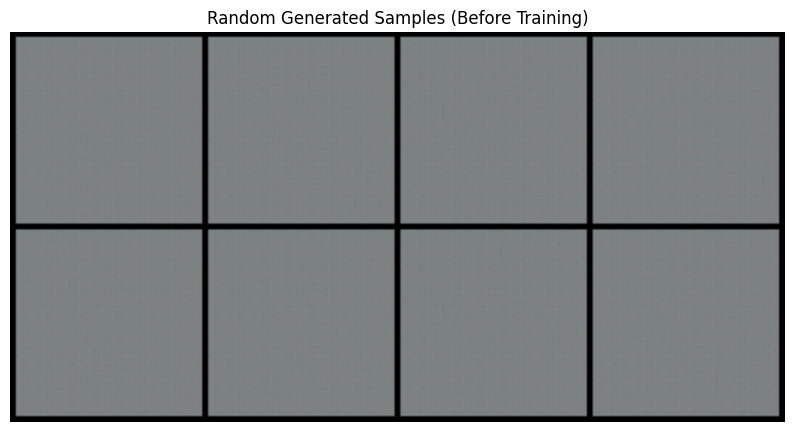

Test completed!

Model Information:
Generator parameters: 5,388,547
Discriminator parameters: 2,790,241
Total parameters: 8,178,788
Estimated parameter memory: 0.03 GB

To start full training, run: main()
To test architecture only, run: test_stylegan_output()


In [96]:
def main():
    """Main training function"""
    print("Starting StyleGAN Training...")

    # Set dataset path (update this)
    dataset_path = '/content/dataset'

    # Visualize dataset first
    print("Visualizing dataset...")
    # category_counts = visualize_dataset(dataset_path)

    # Train model with fewer epochs for demonstration
    print("Training StyleGAN...")
    generator, discriminator, g_losses, d_losses = train_stylegan(
        dataset_path,
        num_epochs=5,  # Reduced for demo - increase for better results
        batch_size=16,  # Reduced for memory efficiency
        lr=0.0002
    )

    # Plot final training history
    print("Plotting final training history...")
    plot_training_history(g_losses, d_losses)

    # Generate final samples
    print("Generating final samples...")
    generate_samples(generator, 16)

    # Save models
    torch.save(generator.state_dict(), '/content/stylegan_generator.pth')
    torch.save(discriminator.state_dict(), '/content/stylegan_discriminator.pth')

    print("Training completed!")
    print("Models saved to /content/")

# Test function to show immediate output
def test_stylegan_output():
    """Test function to show StyleGAN output without full training"""
    print("Testing StyleGAN architecture...")

    # Initialize models
    generator = StyleGANGenerator().to(device)
    discriminator = StyleGANDiscriminator().to(device)

    # Generate random samples
    with torch.no_grad():
        z = torch.randn(8, 512).to(device)
        fake_images = generator(z)

        # Show output shape and sample
        print(f"Generated image shape: {fake_images.shape}")
        print(f"Generated image range: [{fake_images.min():.3f}, {fake_images.max():.3f}]")

        # Visualize samples
        fake_images_cpu = fake_images.cpu()
        fake_images_cpu = (fake_images_cpu + 1) / 2  # Denormalize
        grid = make_grid(fake_images_cpu, nrow=4, padding=2)

        plt.figure(figsize=(10, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title('Random Generated Samples (Before Training)')
        plt.show()

    print("Test completed!")

# Quick demo function
def quick_demo():
    """Quick demonstration of the StyleGAN model"""
    print("=" * 60)
    print("STYLEGAN QUICK DEMO")
    print("=" * 60)

    # Show device info
    print(f"Device: {device}")
    if device.type == 'cuda':
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Test model architecture
    test_stylegan_output()

    # Show model summary
    generator = StyleGANGenerator().to(device)
    discriminator = StyleGANDiscriminator().to(device)

    g_params = sum(p.numel() for p in generator.parameters())
    d_params = sum(p.numel() for p in discriminator.parameters())

    print(f"\nModel Information:")
    print(f"Generator parameters: {g_params:,}")
    print(f"Discriminator parameters: {d_params:,}")
    print(f"Total parameters: {(g_params + d_params):,}")

    # Memory usage estimation
    param_size = (g_params + d_params) * 4 / 1e9  # 4 bytes per float32
    print(f"Estimated parameter memory: {param_size:.2f} GB")

    print("\nTo start full training, run: main()")
    print("To test architecture only, run: test_stylegan_output()")

# Run quick demo
print("Running quick demo...")
quick_demo()

Model Analysis:

Strengths:
- Progressive training allows for stable learning
- Style-based generation provides better control
- Adaptive instance normalization improves quality
- Mapping network enables disentangled representations

Limitations:
- Requires significant computational resources
- Training can be unstable with mode collapse
- Limited by dataset size and quality
- Hyperparameter sensitivity

Possible Improvements:
- Spectral normalization for training stability
- Progressive growing for higher resolution
- Style mixing for better diversity
- Perceptual loss for better quality
Starting StyleGAN Training...
Visualizing dataset...
Training StyleGAN...
Dataset loaded: 30000 images
Batch size: 16, Batches per epoch: 1875
Training for 5 epochs
Generator parameters: 5,388,547
Discriminator parameters: 2,790,241

--- Epoch 1/5 ---
Generator LR: 0.000100
Discriminator LR: 0.000400
  Step [  1/1875] | D_loss: 0.7184 | G_loss: 0.6757 | D_acc: 0.469 | Real_pred: 0.506 | Fake_pred: 0.5

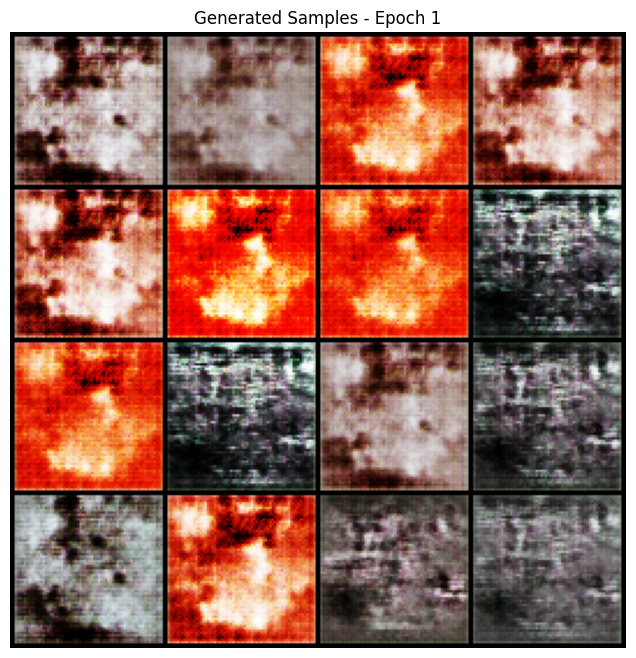


--- Epoch 2/5 ---
Generator LR: 0.000099
Discriminator LR: 0.000396
  Step [  1/1875] | D_loss: 0.5320 | G_loss: 1.2421 | D_acc: 0.875 | Real_pred: 0.581 | Fake_pred: 0.315
  Step [ 11/1875] | D_loss: 0.6393 | G_loss: 1.6067 | D_acc: 0.969 | Real_pred: 0.651 | Fake_pred: 0.211
  Step [ 21/1875] | D_loss: 0.6241 | G_loss: 1.9578 | D_acc: 1.000 | Real_pred: 0.659 | Fake_pred: 0.150
  Step [ 31/1875] | D_loss: 0.3869 | G_loss: 0.9725 | D_acc: 0.906 | Real_pred: 0.750 | Fake_pred: 0.398
  Step [ 41/1875] | D_loss: 0.7067 | G_loss: 1.1484 | D_acc: 0.875 | Real_pred: 0.639 | Fake_pred: 0.352
  Step [ 51/1875] | D_loss: 0.5791 | G_loss: 1.0937 | D_acc: 0.719 | Real_pred: 0.477 | Fake_pred: 0.344
  Step [ 61/1875] | D_loss: 0.4865 | G_loss: 1.5171 | D_acc: 0.875 | Real_pred: 0.710 | Fake_pred: 0.303
  Step [ 71/1875] | D_loss: 0.5801 | G_loss: 1.1964 | D_acc: 0.750 | Real_pred: 0.517 | Fake_pred: 0.316
  Step [ 81/1875] | D_loss: 0.4664 | G_loss: 1.2362 | D_acc: 1.000 | Real_pred: 0.604 | Fak

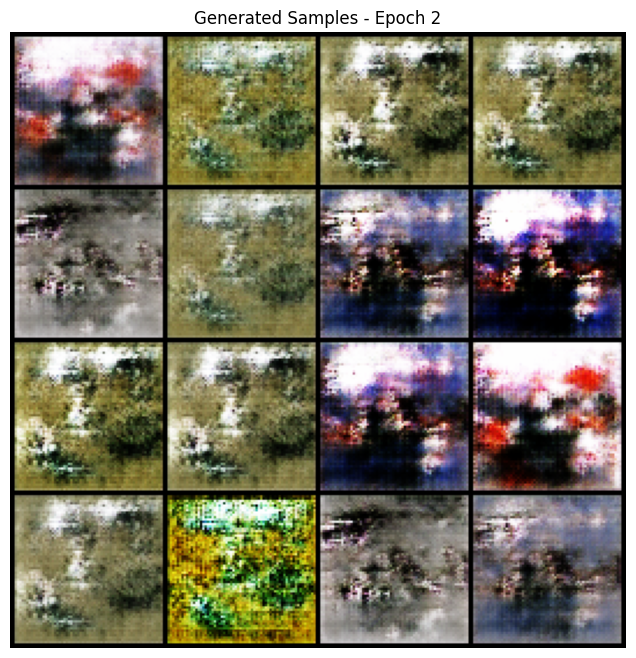

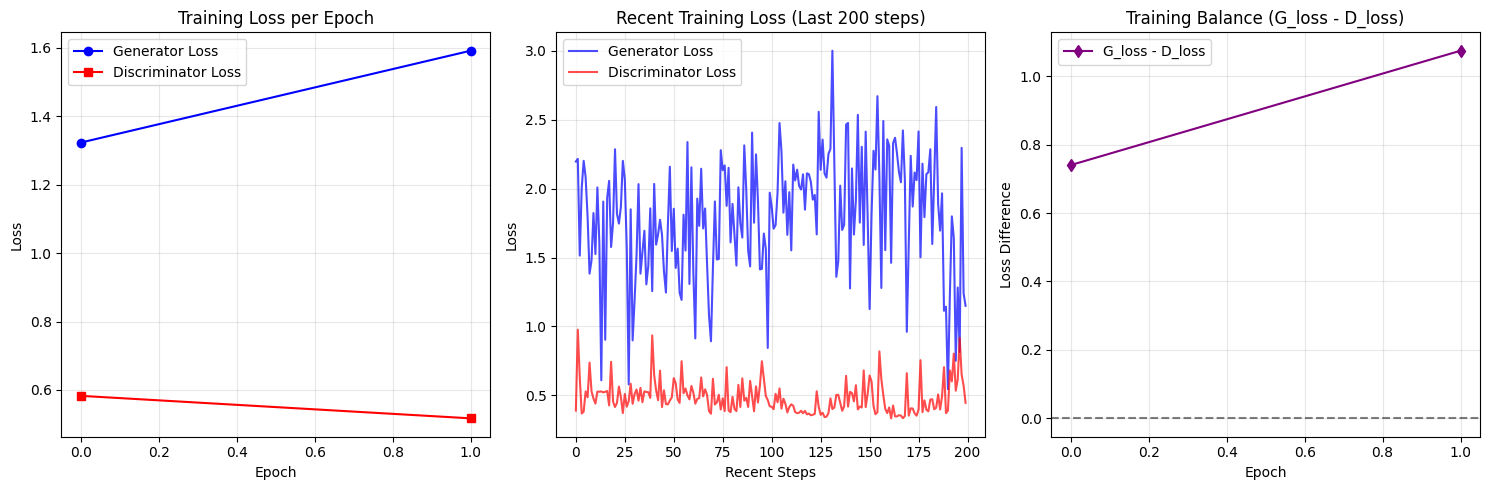


--- Epoch 3/5 ---
Generator LR: 0.000098
Discriminator LR: 0.000392
  Step [  1/1875] | D_loss: 0.5178 | G_loss: 2.1456 | D_acc: 1.000 | Real_pred: 0.774 | Fake_pred: 0.122
  Step [ 11/1875] | D_loss: 0.6275 | G_loss: 1.3609 | D_acc: 1.000 | Real_pred: 0.737 | Fake_pred: 0.273
  Step [ 21/1875] | D_loss: 0.4383 | G_loss: 2.0217 | D_acc: 1.000 | Real_pred: 0.702 | Fake_pred: 0.230
  Step [ 31/1875] | D_loss: 0.5696 | G_loss: 2.0434 | D_acc: 1.000 | Real_pred: 0.799 | Fake_pred: 0.139
  Step [ 41/1875] | D_loss: 0.3833 | G_loss: 2.4641 | D_acc: 1.000 | Real_pred: 0.776 | Fake_pred: 0.118
  Step [ 51/1875] | D_loss: 0.3584 | G_loss: 2.3726 | D_acc: 1.000 | Real_pred: 0.892 | Fake_pred: 0.131
  Step [ 61/1875] | D_loss: 0.3552 | G_loss: 1.3461 | D_acc: 1.000 | Real_pred: 0.793 | Fake_pred: 0.269
  Step [ 71/1875] | D_loss: 0.5371 | G_loss: 2.3296 | D_acc: 0.969 | Real_pred: 0.605 | Fake_pred: 0.104
  Step [ 81/1875] | D_loss: 0.3489 | G_loss: 2.0999 | D_acc: 1.000 | Real_pred: 0.803 | Fak

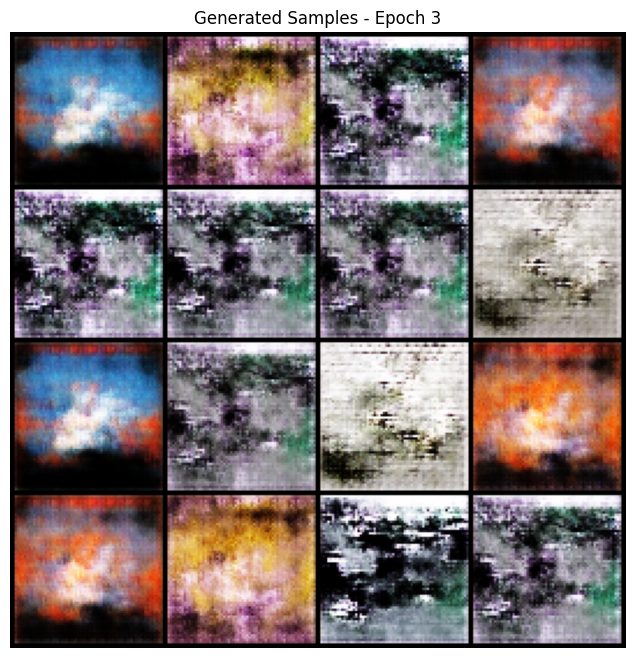

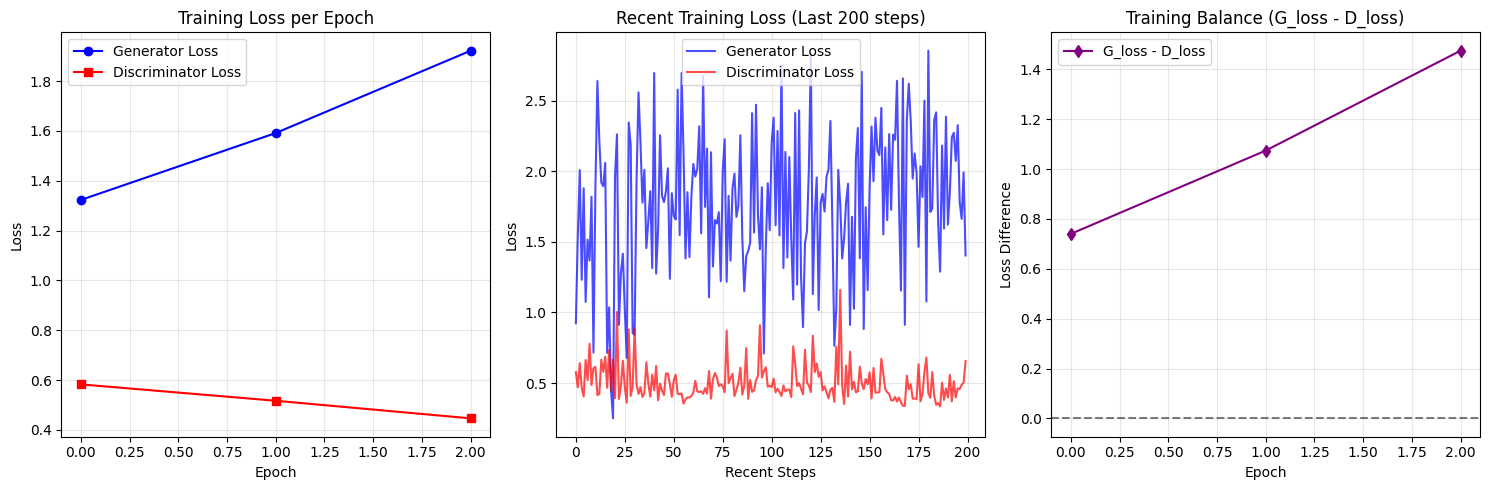


--- Epoch 4/5 ---
Generator LR: 0.000097
Discriminator LR: 0.000388
  Step [  1/1875] | D_loss: 0.4208 | G_loss: 2.3893 | D_acc: 1.000 | Real_pred: 0.801 | Fake_pred: 0.142
  Step [ 11/1875] | D_loss: 0.7016 | G_loss: 0.6420 | D_acc: 0.250 | Real_pred: 0.374 | Fake_pred: 0.530
  Step [ 21/1875] | D_loss: 0.8864 | G_loss: 0.8384 | D_acc: 0.906 | Real_pred: 0.605 | Fake_pred: 0.443
  Step [ 31/1875] | D_loss: 0.5624 | G_loss: 1.5248 | D_acc: 0.969 | Real_pred: 0.607 | Fake_pred: 0.229
  Step [ 41/1875] | D_loss: 0.6481 | G_loss: 1.3272 | D_acc: 0.594 | Real_pred: 0.413 | Fake_pred: 0.268
  Step [ 51/1875] | D_loss: 0.4212 | G_loss: 2.6865 | D_acc: 0.969 | Real_pred: 0.760 | Fake_pred: 0.153
  Step [ 61/1875] | D_loss: 0.6626 | G_loss: 1.9385 | D_acc: 1.000 | Real_pred: 0.792 | Fake_pred: 0.151
  Step [ 71/1875] | D_loss: 0.4185 | G_loss: 1.4644 | D_acc: 0.938 | Real_pred: 0.702 | Fake_pred: 0.254
  Step [ 81/1875] | D_loss: 0.5767 | G_loss: 0.8014 | D_acc: 0.656 | Real_pred: 0.521 | Fak

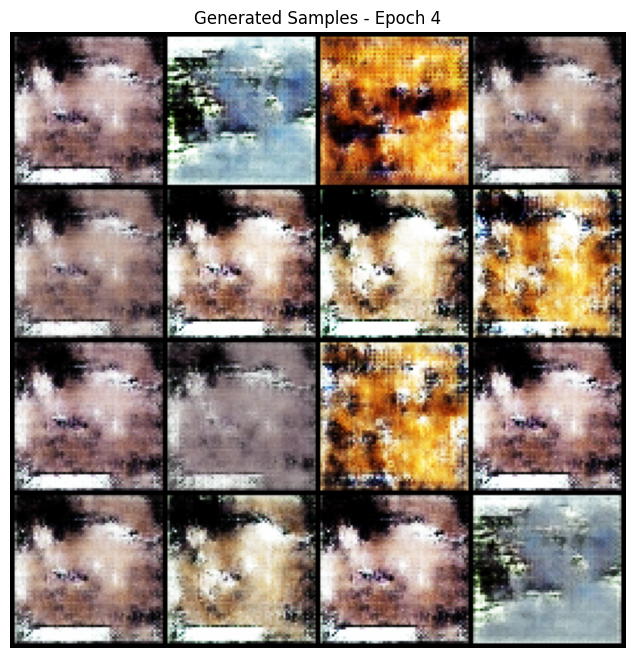

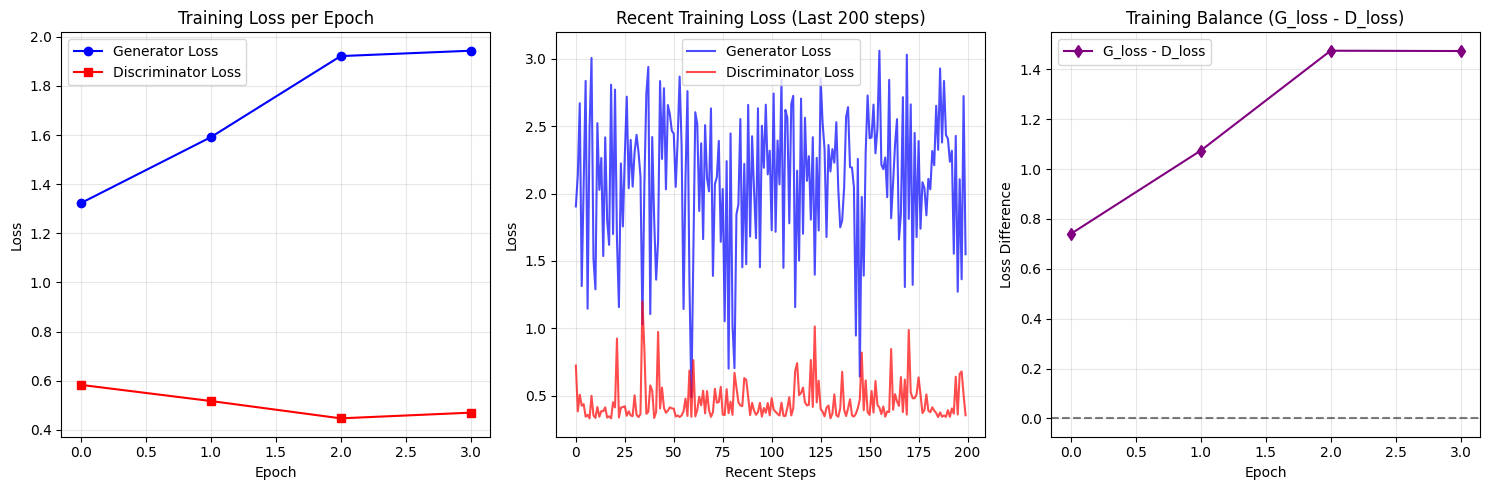


--- Epoch 5/5 ---
Generator LR: 0.000096
Discriminator LR: 0.000384
  Step [  1/1875] | D_loss: 0.4068 | G_loss: 3.0805 | D_acc: 1.000 | Real_pred: 0.832 | Fake_pred: 0.050
  Step [ 11/1875] | D_loss: 0.3913 | G_loss: 2.8363 | D_acc: 1.000 | Real_pred: 0.911 | Fake_pred: 0.064
  Step [ 21/1875] | D_loss: 0.3395 | G_loss: 2.0217 | D_acc: 1.000 | Real_pred: 0.856 | Fake_pred: 0.139
  Step [ 31/1875] | D_loss: 0.3879 | G_loss: 2.3413 | D_acc: 1.000 | Real_pred: 0.872 | Fake_pred: 0.105
  Step [ 41/1875] | D_loss: 0.4133 | G_loss: 2.3307 | D_acc: 1.000 | Real_pred: 0.815 | Fake_pred: 0.136
  Step [ 51/1875] | D_loss: 0.3584 | G_loss: 2.6588 | D_acc: 1.000 | Real_pred: 0.791 | Fake_pred: 0.077
  Step [ 61/1875] | D_loss: 0.3413 | G_loss: 1.5705 | D_acc: 1.000 | Real_pred: 0.837 | Fake_pred: 0.210
  Step [ 71/1875] | D_loss: 0.3849 | G_loss: 2.4806 | D_acc: 1.000 | Real_pred: 0.869 | Fake_pred: 0.087
  Step [ 81/1875] | D_loss: 0.3591 | G_loss: 3.1103 | D_acc: 1.000 | Real_pred: 0.875 | Fak

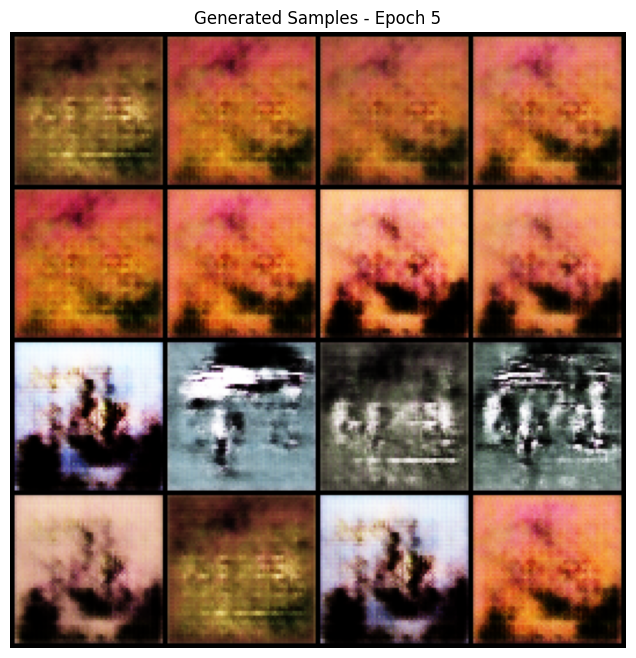

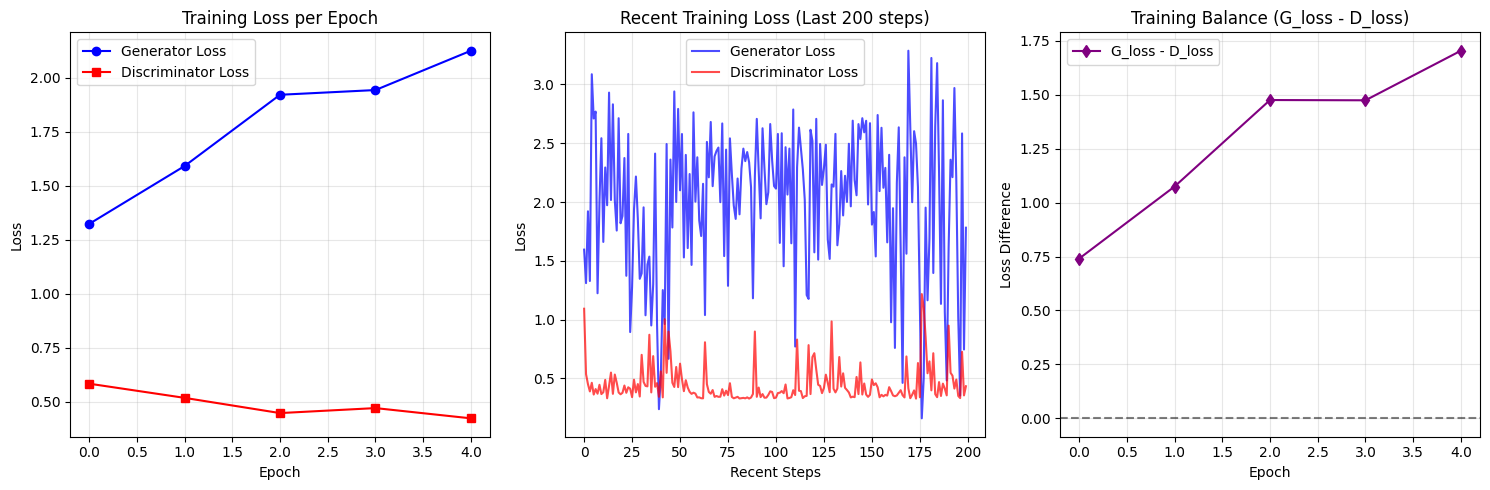


Training completed!
Final Generator Loss: 2.1260
Final Discriminator Loss: 0.4221
Final Loss Difference: 1.7039
Recent Generator Stability (std): 0.0915
Recent Discriminator Stability (std): 0.0194
Plotting final training history...


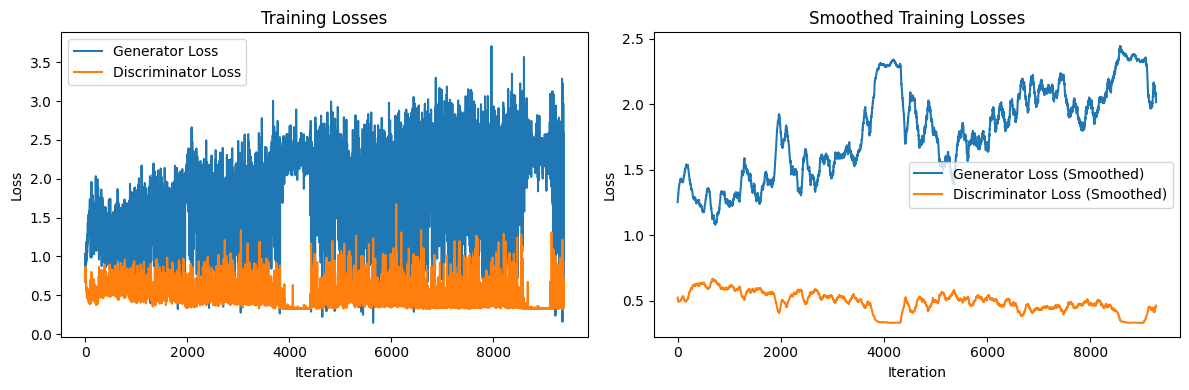

Generating final samples...


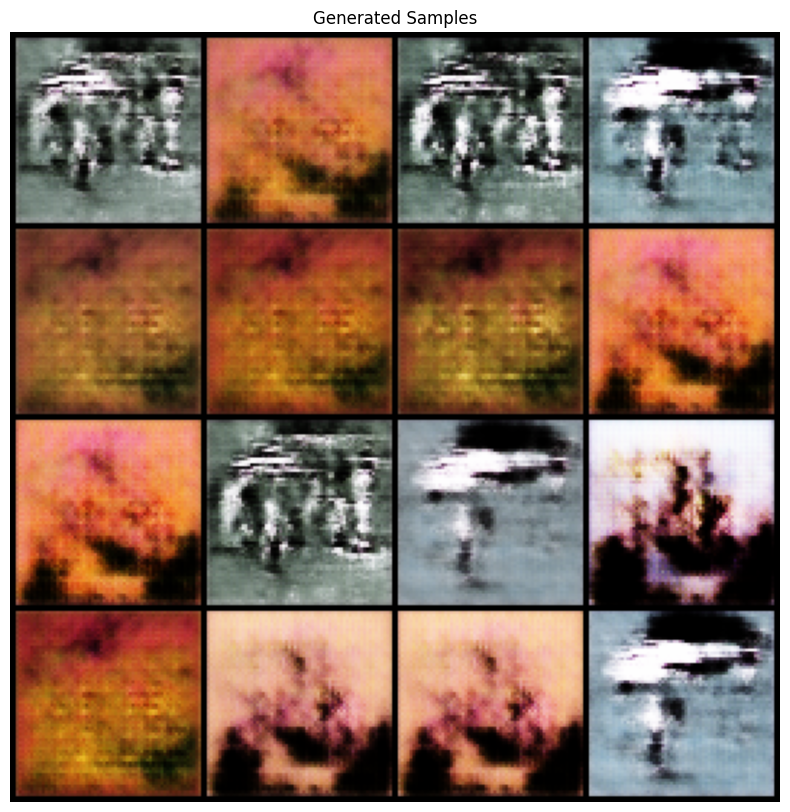

Training completed!
Models saved to /content/


In [97]:
# 7. Improvements and Analysis
# =============================================

def analyze_model_performance():
    """Analyze model strengths and limitations"""
    analysis = {
        'strengths': [
            'Progressive training allows for stable learning',
            'Style-based generation provides better control',
            'Adaptive instance normalization improves quality',
            'Mapping network enables disentangled representations'
        ],
        'limitations': [
            'Requires significant computational resources',
            'Training can be unstable with mode collapse',
            'Limited by dataset size and quality',
            'Hyperparameter sensitivity'
        ],
        'improvements': [
            'Spectral normalization for training stability',
            'Progressive growing for higher resolution',
            'Style mixing for better diversity',
            'Perceptual loss for better quality'
        ]
    }

    print("Model Analysis:")
    print("=" * 50)

    print("\nStrengths:")
    for strength in analysis['strengths']:
        print(f"- {strength}")

    print("\nLimitations:")
    for limitation in analysis['limitations']:
        print(f"- {limitation}")

    print("\nPossible Improvements:")
    for improvement in analysis['improvements']:
        print(f"- {improvement}")

# Run analysis
analyze_model_performance()

# Call the main training function
main()